<a href="https://colab.research.google.com/github/datvodinh10/Skin-Cancer-MNIST/blob/main/Skin_Cancer_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clone and Import data

In [1]:
!git clone https://github.com/datvodinh10/Skin-Cancer-MNIST.git

Cloning into 'Skin-Cancer-MNIST'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 76 (delta 0), reused 5 (delta 0), pack-reused 70
Unpacking objects: 100% (76/76), 33.37 MiB | 6.25 MiB/s, done.


In [2]:
! pip -q install kaggle

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv /content/Skin-Cancer-MNIST/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [00:41<00:00, 188MB/s]
100% 5.20G/5.20G [00:41<00:00, 133MB/s]


In [5]:
import zipfile

In [6]:
!unzip -q /content/skin-cancer-mnist-ham10000.zip

## Import

In [7]:
from tqdm import tqdm
from glob import glob
from PIL import Image
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Preprocessing data

In [9]:
data_dir = './'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

In [10]:
classes = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [11]:
df_metadata = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_metadata['path'] = df_metadata['image_id'].map(imageid_path_dict.get)
df_metadata['cell_type'] = df_metadata['dx'].map(classes.get)
df_metadata['cell_type_idx'] = pd.Categorical(df_metadata['cell_type']).codes
df_metadata.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
2776,HAM_0004042,ISIC_0026978,bcc,histo,80.0,male,upper extremity,./HAM10000_images_part_1/ISIC_0026978.jpg,Basal cell carcinoma,1
2467,HAM_0007009,ISIC_0027146,bcc,histo,50.0,male,back,./HAM10000_images_part_1/ISIC_0027146.jpg,Basal cell carcinoma,1
239,HAM_0003659,ISIC_0033449,bkl,histo,85.0,male,upper extremity,./HAM10000_images_part_2/ISIC_0033449.jpg,Benign keratosis-like lesions,2


In [12]:
df_metadata['image'] = df_metadata['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [13]:
df_metadata.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
5286,HAM_0004785,ISIC_0030788,nv,follow_up,60.0,male,back,./HAM10000_images_part_2/ISIC_0030788.jpg,Melanocytic nevi,4,"[[[213, 122, 122], [216, 125, 130], [220, 129,..."
8942,HAM_0007385,ISIC_0030920,nv,histo,30.0,male,scalp,./HAM10000_images_part_2/ISIC_0030920.jpg,Melanocytic nevi,4,"[[[156, 128, 116], [158, 130, 120], [162, 135,..."
253,HAM_0004029,ISIC_0029472,bkl,histo,65.0,male,upper extremity,./HAM10000_images_part_2/ISIC_0029472.jpg,Benign keratosis-like lesions,2,"[[[152, 151, 156], [161, 159, 162], [170, 166,..."


In [14]:
features=df_metadata['image']
label=df_metadata['cell_type_idx']

In [15]:
X_train,X_test,y_train,y_test = train_test_split(features,label,test_size=0.2,random_state=0,stratify=label)

In [16]:
X_train = np.asarray(X_train.tolist())
X_test = np.asarray(X_test.tolist())
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [17]:
X_train.shape

(8012, 75, 100, 3)

In [18]:
x_train_mean = np.mean(X_train)
x_train_std = np.std(X_train)

X_train = (X_train - x_train_mean) / (x_train_std + 1e-8)
X_test = (X_test - x_train_mean) / (x_train_std + 1e-8)

In [19]:
one_hot = OneHotEncoder()
y_train = one_hot.fit_transform(y_train.reshape(-1,1)).toarray()
y_test  = one_hot.transform(y_test.reshape(-1,1)).toarray()

In [20]:
X_train = torch.tensor(X_train,dtype=torch.float32).to(device=device)
X_test= torch.tensor(X_test,dtype=torch.float32).to(device=device)
y_train = torch.tensor(y_train,dtype=torch.float32).to(device=device)
y_test = torch.tensor(y_test,dtype=torch.float32).to(device=device)

In [21]:
df_metadata.sample(1)['image']

1359    [[[23, 10, 17], [21, 9, 17], [28, 16, 23], [43...
Name: image, dtype: object

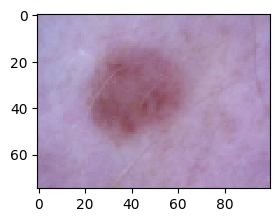

In [22]:
plt.figure(figsize=(3,4))
plt.imshow(np.asarray(df_metadata.sample(1)['image'].tolist()).squeeze(0), interpolation='nearest')

## Data Augmentation

## Visualize data

In [ ]:
df = pd.read_csv('./hmnist_28_28_RGB.csv')

In [ ]:
plt.figure(figsize=(12,6))
for i in range(1,11):
    plt.subplot(2,5,i)
    idx = np.random.randint(0,5000)
    plt.imshow(np.array(df)[idx][:-1].reshape(28,28,3), interpolation='nearest')
    plt.xlabel(list(classes.keys())[np.array(df)[idx][-1]])

In [ ]:
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique((y_train)),y=y_train)
class_weights = torch.from_numpy(class_weights)

## Torch DataLoader

## Data Prepocessing

In [24]:
def DataLoader(X_train,y_train,batch_size=64):
    """Split data into batch"""
    n = X_train.shape[0]
    idx = torch.randperm(n)
    X_new,y_new = X_train[idx],y_train[idx]
    for i in range(0,n,batch_size):
        begin,end = i, min(i+batch_size,n)
        yield X_new[begin:end],y_new[begin:end]

def FitModel(X_train,X_test,y_train,y_test,model,criterion,optimizer,epoch,batch_size):
    train_acc_list = []
    val_acc_list   = []
    for e in range(epoch):
        total_loss = 0
        for x,y in DataLoader(X_train,y_train,batch_size):
            y_pred = model.forward(x)
            loss = criterion(y_pred,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss+=loss.detach().item()
            # print(loss.detach().item())
        total_loss /= int(X_train.shape[0] / batch_size)
        with torch.no_grad():
            y_train_pred = model.forward(X_train).cpu()
            y_test_pred  = model.forward(X_test).cpu()
            train_acc = torch.mean((torch.argmax(y_train_pred,dim=1)==torch.argmax(y_train,dim=1)) * 1.0)
            val_acc   = torch.mean((torch.argmax(y_test_pred,dim=1)==torch.argmax(y_test,dim=1)) * 1.0)
            print(f'EPOCH {e:>5} | LOSS: {total_loss:.4f} | TRAIN ACC: {train_acc* 100:.2f}% | VAL ACC: {val_acc*100:.2f}% |')
    
    Plot(train_acc_list,val_acc_list)

def Plot(train_acc_list,train_val_list):
    pass

## CNN

In [31]:
cnn_model = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Dropout(p=0.5),
    nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Dropout(p=0.5),
    nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Dropout(p=0.5),
    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Dropout(p=0.5),
    nn.Flatten(1),
    nn.Linear(512,64),
    nn.ReLU(),
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(32,7)



)
optimizer = torch.optim.Adam(cnn_model.parameters(),lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()


In [ ]:
FitModel(X_train.view(-1,3,75,100),X_test.view(-1,3,75,100),y_train,y_test,
         model=cnn_model,
         criterion=criterion,
         optimizer=optimizer,
         epoch=50,
         batch_size=32)

EPOCH     0 | LOSS: 0.7303 | TRAIN ACC: 72.20% | VAL ACC: 70.99% |
EPOCH     1 | LOSS: 0.7354 | TRAIN ACC: 71.53% | VAL ACC: 70.29% |
EPOCH     2 | LOSS: 0.7284 | TRAIN ACC: 72.38% | VAL ACC: 70.59% |
EPOCH     3 | LOSS: 0.7410 | TRAIN ACC: 73.00% | VAL ACC: 71.24% |


In [35]:
a = torch.bincount(torch.argmax(y_train,dim=1))

In [36]:
max(a) / sum(a)

tensor(0.6695)